# Welch's two-sample $t$-test

The goal of Welch's two-sample $t$-test to check if the means two unknown population $X \sim \mathcal{N}(\mu_X, \sigma_X)$ and $Y \sim \mathcal{N}(\mu_Y, \sigma_Y)$
are the same or different.

For statistical design considerations related to two-sample tests,
see the notebook [`statistical_design.ipynb`](./statistical_design.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\widehat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

## Data
Two samples of numerical observations $\mathbf{x}=[x_1, x_2, \ldots, x_n]$
and $\mathbf{y}=[y_1, y_2,\ldots, y_m]$ from independent populations.

## Assumptions

We assume the unknown populations are normally distributed $\textbf{(NORM)}$,
or the sample is large enough $\textbf{(LARGEn)}$,
so that the sampling distributions of the means in the two populations will be approximately normally distributed:

$$
  \overline{\mathbf{X}} \sim \mathcal{N}\left(\mu_X, \frac{\sigma_X}{n}\right)
  \qquad
  \text{and}
  \qquad
  \overline{\mathbf{Y}} \sim \mathcal{N}\left(\mu_Y, \frac{\sigma_Y}{n}\right),
$$
where $\sigma_X$ and $\sigma_Y$ are the standard deviations of the unknown populations.

## Hypotheses

$H_0: \mu_X = \mu_Y$ and $H_A: \mu_X \neq \mu_Y$.

## Estimates

Compute the sample means
$\overline{\mathbf{x}} = \Mean(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n x_i$,
$\overline{\mathbf{y}} = \Mean(\mathbf{y}) = \frac{1}{m}\sum_{i=1}^m y_i$,
and the observed difference between means
$\hat{d} = \DMeans(\mathbf{x}, \mathbf{y}) = \overline{\mathbf{x}} - \overline{\mathbf{y}}$.

We need to also compute the standard deviations
$s_{\mathbf{x}} = \Std(\mathbf{x}) = \sqrt{ \frac{1}{n-1}\sum_{i=1}^n (x_i-\overline{\mathbf{x}})^2 }$
and 
$s_{\mathbf{y}} = \Std(\mathbf{y}) = \sqrt{ \frac{1}{m-1}\sum_{i=1}^m (y_i-\overline{\mathbf{y}})^2 }$,
which are estimates for the unknown population standard deviations $\sigma_X$ and $\sigma_Y$.

## Formulas

The estimated standard error of the difference-between-means estimator is

$$
  \stderrhat{\hat{d}}
        \; = \; \sqrt{  \stderrhat{\overline{\mathbf{x}}}^2 + \stderrhat{\overline{\mathbf{y}}}^2 }
        = \sqrt{ \tfrac{s_{\mathbf{x}}^2}{n} + \tfrac{s_{\mathbf{y}}^2}{m} },
$$

where $s_{\mathbf{x}}$ and $s_{\mathbf{y}}$ are the sample standard deviations.


The Welch--Satterthwaite formula for the degrees of freedom parameter $\nu_d$ is

$$
\nu_d
    \;\; = \;\;
    \frac{ 	\big(\stderrhat{\overline{\mathbf{x}}}^2 + \stderrhat{\overline{\mathbf{y}}}^2\big)^2 }
         {	\tfrac{\stderrhat{\overline{\mathbf{x}}}^4}{n-1} + \tfrac{\stderrhat{\overline{\mathbf{y}}}^4}{m-1}	}.
$$

In Python, we can calculate $\nu_d$ by calling the helper function `calcdf`:
$\nu_d = \tt{calcdf}(s_{\mathbf{x}}, n, s_{\mathbf{y}}, m)$.

## Test statistic

Compute the $t$-statistic $t = \frac{\hat{d} - 0}{ \stderrhat{\hat{d}} }$.

## Sampling distribution

Student's $t$-distribution with $\nu_d$ degrees of freedom,
where the degrees of freedom parameter is computed using
the helper function `calcdf`:
$\nu_d = \tt{calcdf}(s_{\mathbf{x}}, n, s_{\mathbf{y}}, m)$,
which implements the Welch--Satterthwaite formula.

## P-value calculation

To obtain the $p$-value,
we first compute the observed $t$-statistic,
then calculate the tail probabilities in the two tails of the standard normal distribution $T_0 \sim \mathcal{T}(\nu_d)$.

In [3]:
from ministats import ttest_dmeans
from scipy.stats import ttest_ind

Let's look at the source code of the function `ttest_dmeans`,
which performs the steps of the two-sample t-test.

```Python
import numpy as np
from scipy.stats import t as tdist
from ministats import mean, std, calcdf, tailprobs

def ttest_dmeans(xsample, ysample, alt="two-sided"):
    """
    T-test to detect difference between two populations means
    based on the difference between sample means.
    """
    # Calculate the observed difference between means
    obsdhat = mean(xsample) - mean(ysample)

    # Calculate the sample sizes and the stds
    n, m = len(xsample), len(ysample)
    sx, sy = std(xsample), std(ysample)

    # Calculate the standard error, the degrees of
    # freedom, the null model, and the t-statistic
    seD = np.sqrt(sx**2/n + sy**2/m)
    obst = (obsdhat - 0) / seD
    dfD = calcdf(sx, n, sy, m)
    rvT0 = tdist(df=dfD)

    # Calculate the p-value from the t-distribution
    pvalue = tailprobs(rvT0, obst, alt=alt)
    return pvalue
```

See Section 3.5 in the **No Bullshit Guide to Statistics** for the detailed explanation of these steps.
You can also check out the section **Analytical approximation methods** in the notebook [notebooks/35_two_sample_tests.ipynb](../notebooks/35_two_sample_tests.ipynb#Analytical-approximation-methods).

To perform the two-sample $t$-test on the samples `xs` and `ys`,
we call `ttest_dmeans(xs, ys)` or `ttest_ind(xs, ys, equal_var=False)`,
as we'll show in the [Examples](#Examples) section below.

## Effect size estimates

In [4]:
from ministats import ci_dmeans


```Python
import numpy as np
from scipy.stats import t as tdist
from ministats import calcdf

def ci_dmeans(xsample, ysample, alpha=0.1):
    """
    Compute confidence interval for the difference between population means.
    """
    stdX, n = np.std(xsample, ddof=1), len(xsample)
    stdY, m = np.std(ysample, ddof=1), len(ysample)
    dhat = np.mean(xsample) - np.mean(ysample)
    seD = np.sqrt(stdX**2/n + stdY**2/m)
    dfD = calcdf(stdX, n, stdY, m)
    t_l = tdist(df=dfD).ppf(alpha/2)
    t_u = tdist(df=dfD).ppf(1-alpha/2)
    return [dhat + t_l*seD, dhat + t_u*seD]
```

TODO: narrate code

To use the function ...

## Related

1. The two-sample t-test is an improved version of the two-sample z-test
1. The Welch's two-sample t-test always a better option than the two-sample t-test with pooled variance
1. An alternative approach for comparing two groups is to use the permutation test (TODO link to nb)
1. Another alternative is to use the linear model (TODO: deep link to the everything is a LM)


## Examples

Let's start by generating some samples from the following three populations
for use in the examples we present below.

$$
    A \sim \mathcal{N}(\mu_A= 104, \sigma_A=3),
    \qquad
    B \sim \mathcal{N}(\mu_B=100,\sigma_B=5),
    \quad
    \text{and}
    \quad
    C \sim \mathcal{N}(\mu_C=100,\sigma_C=5).
$$

Note populations $B$ and $C$ are identical.

We'll now generate a samples of size $n=20$ from each of these populaitons
and store them in a Pandas data frame called `data`.

In [5]:
from scipy.stats import norm

np.random.seed(42)

n = 20   # sample size

# Sample A: size = 20, population = N(104,3)
avals = norm(104,3).rvs(n)
dataA = pd.DataFrame({"pop":["A"]*n, "val":avals})

# Sample B: size=20, population = N(100,5)
bvals = norm(100,5).rvs(n)
dataB = pd.DataFrame({"pop":["B"]*n, "val":bvals})

# Sample C: size=20, same population as Sample B
cvals = norm(100,5).rvs(n)
dataC = pd.DataFrame({"pop":["C"]*n, "val":cvals})

data = pd.concat([dataA, dataB, dataC])

### Example 1: populations are different

We'll now apply the Welch's two-sample t-test to compare the samples from population A and B,
which we know are different.

In [6]:
avals = data[data["pop"]=="A"]["val"]
bvals = data[data["pop"]=="B"]["val"]

The sample means seem to reflect the difference between population means too...

In [7]:
avals.mean(), bvals.mean()

(103.48610431567451, 98.67012442302976)

... but we must consider the difference between means relative to the standard deviations of the two samples.

In [8]:
avals.std(), bvals.std()

(2.880085264317079, 4.840193546088457)

Here is a picture that shows the data points,
the sample means, and the sample standard deviations for the two samples.

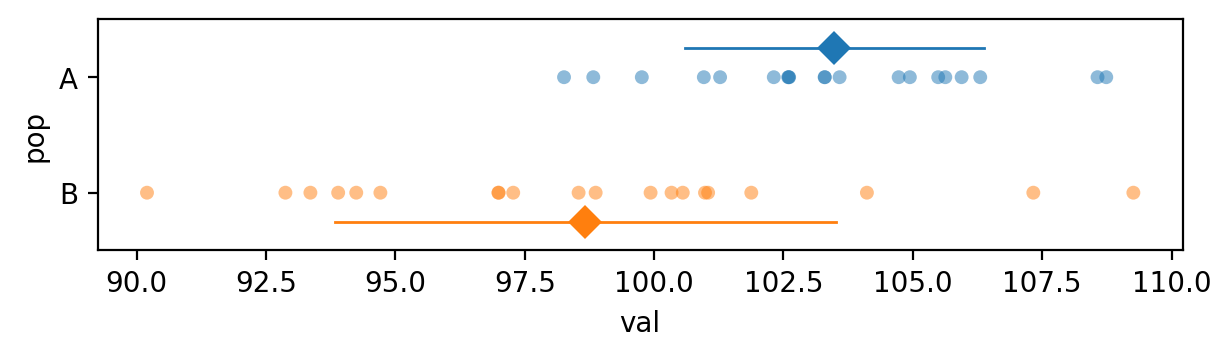

In [9]:
import seaborn as sns

data1 = data[data["pop"].isin(["A","B"])]
with plt.rc_context({"figure.figsize":(7,1.5)}):
    sns.stripplot(data=data1, x="val", y="pop", hue="pop", jitter=0, alpha=0.5)
    sns.pointplot(data=data1, x="val", y="pop", hue="pop", dodge=0.5, estimator="mean",
                  errorbar="sd", marker="D", err_kws={"linewidth":1})

Let's now use the helper function `ttest_dmeans` to perform the two-sample t-test calculation
and obtain the $p$-value.

In [10]:
from ministats import ttest_dmeans

ttest_dmeans(avals, bvals)

0.0005953205918276521

The $p$-value we obtain is 0.000595,
which is below the cutoff value $\alpha=0.05$,
so our conclusion is **we reject the null hypothesis**:
the difference between the means of the two unknown populations is statistically significant.

In [11]:
# # ALT.
# from scipy.stats import ttest_ind
# ttest_ind(avals, bvals, equal_var=False)[1]

#### Effect size

The confidence interval for the effect size $\Delta = \mu_A - \mu_B$ is

In [12]:
ci_dmeans(avals, bvals, alpha=0.1, method='a')

[2.6805293784320785, 6.951430406857417]

### Example 2: two samples from the same population

Let's now analyze the samples from populations B and C that come from the same distribution,
which is the situation described by the null hypothesis.

In [13]:
bvals = data[data["pop"]=="B"]["val"]
cvals = data[data["pop"]=="C"]["val"]

bvals.mean(), cvals.mean()

(98.67012442302976, 99.86654813812206)

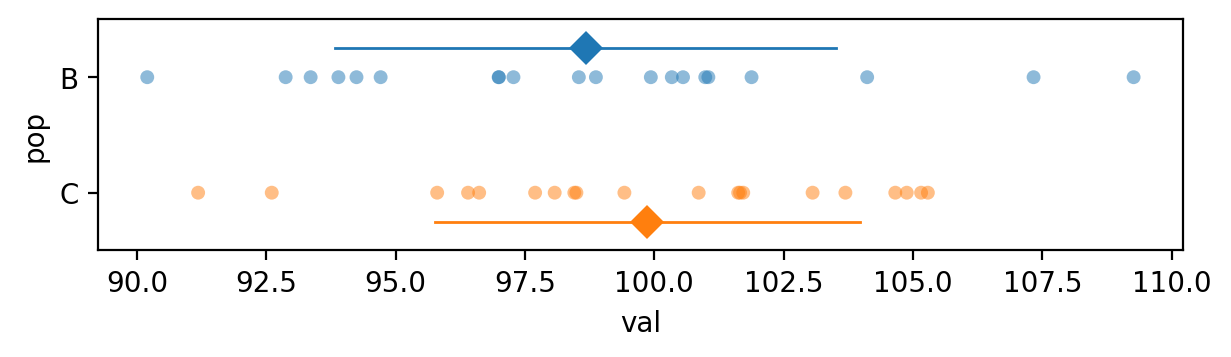

In [14]:
data2 = data[data["pop"].isin(["B", "C"])]

with plt.rc_context({"figure.figsize":(7,1.5)}):
    sns.stripplot(data=data2, x="val", y="pop", hue="pop", jitter=0, alpha=0.5)
    sns.pointplot(data=data2, x="val", y="pop", hue="pop", dodge=0.5, estimator="mean",
                  errorbar="sd", marker="D", err_kws={"linewidth":1})

In [15]:
from ministats import ttest_dmeans

ttest_dmeans(bvals, cvals)

0.4045691564236631

The $p$-value we obtain is 0.40, which is above the cutoff value $\alpha=0.05$
so our conclusion is that we've **failed to reject the null hypothesis**:
the means of two samples are not significantly different.

#### Effect size

The confidence interval for the effect size $\Delta = \mu_B - \mu_C$ is

In [16]:
ci_dmeans(bvals, cvals, alpha=0.1, method='a')

[-3.590421559991184, 1.1975741298065947]

### Example 3: Lalonde dataset

see original paper https://business.baylor.edu/scott_cunningham/teaching/lalonde-1986.pdf  
and these links for more info: https://www.one-tab.com/page/h_npVXMeTp2T7Dm5fAlDqw


In [17]:
import pandas as pd
lalonde = pd.read_csv("../datasets/lalonde.csv")
# lalonde.head()

In [18]:
control = lalonde[lalonde["Training"]==False]
treated = lalonde[lalonde["Training"]==True]
# control.describe()
# treated.describe()

In [19]:
# The means of the two groups
treated["Wage_1978"].mean(), control["Wage_1978"].mean()

(6349.143530270271, 4554.801126)

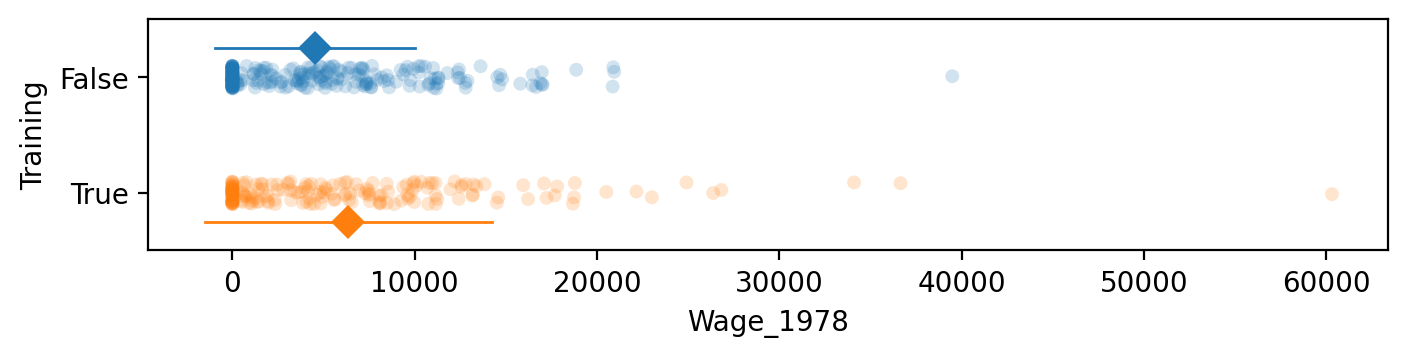

In [20]:
with plt.rc_context({"figure.figsize":(8,1.5)}):
    sns.stripplot(data=lalonde, x="Wage_1978", y="Training", hue="Training",
                  orient="h", alpha=0.2)
    sns.pointplot(data=lalonde, x="Wage_1978", y="Training", hue="Training", dodge=0.5,
                  orient="h", estimator="mean",
                  errorbar="sd", marker="D", err_kws={"linewidth":1})
    plt.legend().remove()

In [21]:
from scipy.stats import ttest_ind

ttest_ind(treated["Wage_1978"], control["Wage_1978"], equal_var=False)

TtestResult(statistic=2.674145513783345, pvalue=0.007892977714517335, df=307.1324931115885)

#### Effect size

In [22]:
from ministats import cohend2

cohend2(treated["Wage_1978"], control["Wage_1978"])

0.27271540735846456

### Example 4: analysis of a dataset that contains outliers

The dataset `outliers2.csv` consists of measurements of "soil score" variable
using a specialized equipment for calculating soil quality.

The measurement apparatus has an upper limit beyound which it doesn't function properly,
so all observations that exceed this limit are recorded as the value 2500.

In [23]:
outliers2 = pd.read_csv("../datasets/outliers2.csv")
outliers2.groupby("group").describe()

score                                                                
      count         mean          std   min     25%    50%      75%     max
group                                                                      
A      14.0   482.857143   681.137833  26.0   82.50  153.5   715.75  2500.0
B      18.0  1213.611111  1099.014486  26.0  198.75  830.0  2500.00  2500.0

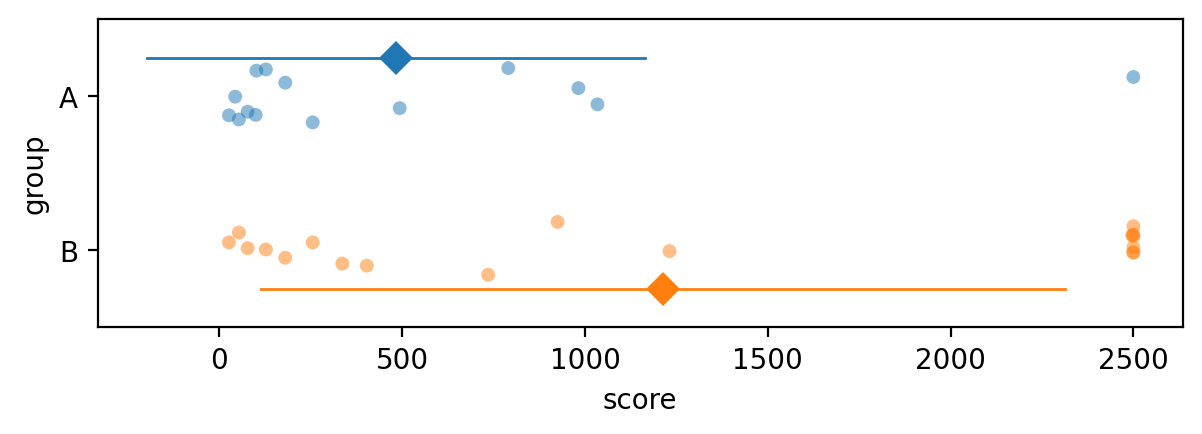

In [24]:
with plt.rc_context({"figure.figsize":(7,2)}):
    sns.stripplot(data=outliers2, x="score", y="group", hue="group", jitter=0.2, alpha=0.5)
    sns.pointplot(data=outliers2, x="score", y="group", hue="group", dodge=0.5, estimator="mean",
                  errorbar="sd", marker="D", err_kws={"linewidth":1})

The effect of the outliers in group B is to pull the mean up,
to a much higher value than where the other data points are.

In [25]:
from scipy.stats import ttest_ind

scoresA = outliers2[outliers2["group"]=="A"]["score"]
scoresB = outliers2[outliers2["group"]=="B"]["score"]
obst, pvalue = ttest_ind(scoresA, scoresB, equal_var=False)
pvalue

0.028387263383781086

The outliers pull the mean in group B to a high value,
which leads us to conclude there is a statistically significant difference between the two groups.
This is because we're using the $t$-test when the normality assumption is not valid.

See the example notebook [`Mann-Whitney_U-test.ipynb`](./Mann-Whitney_U-test.ipynb) for an analysis of this data
using the nonparametric test for comparing two groups,
which is more appropriate for data with outliers.

## Discussion

## Links

1. For more details about the Welch's two-sample t-test,
   see the notebook [`notebooks/35_two_sample_tests.ipynb`](../notebooks/35_two_sample_tests.ipynb),
   which contains a more detailed derivation.

1. See the Section 3.5 exercises notebook:
   [exercises/exercises_35_two_sample_tests.ipynb](../exercises/exercises_35_two_sample_tests.ipynb)
   for practice problems.

   